In [3]:
import pandas as pd
from datetime import timedelta

def calculate_sleep_cycle_length(file_path):
    """
    Calculate sleep cycle length from a CSV file.

    Args:
        file_path (str): Path to the CSV file. The CSV should have 'Timestamp' and 'sleepStage' columns.

    Returns:
        List[Tuple[Timestamp, Timestamp, timedelta]]: A list of tuples containing start and end timestamps and the cycle length.
    """
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Ensure proper datetime format for the Timestamp column
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Sort by Timestamp to ensure sequential order
    data = data.sort_values(by='Timestamp').reset_index(drop=True)

    # Initialize variables
    rem_end_indices = []  # Stores indices where sleepStage transitions from REM (3) to other
    result = []

    # Detect the end of REM sleep stages (sleepStage=3)
    for i in range(1, len(data)):
        if data.loc[i - 1, 'sleepStage'] == 3 and data.loc[i, 'sleepStage'] != 3:
            rem_end_indices.append(i - 1)

    # Calculate the intervals between successive REM sleep stages
    for i in range(1, len(rem_end_indices)):
        start_idx = rem_end_indices[i - 1]
        end_idx = rem_end_indices[i]

        # Check the time between start_idx and end_idx to ensure conditions
        segment = data.iloc[start_idx + 1:end_idx + 1]
        valid = all(
            (segment['sleepStage'] == 1) | (segment['sleepStage'] == 'awake')
        ) and (segment['Timestamp'].diff().max() <= pd.Timedelta(seconds=2))

        if valid:
            start_time = data.loc[start_idx, 'Timestamp']
            end_time = data.loc[end_idx, 'Timestamp']
            cycle_length = end_time - start_time
            result.append((start_time, end_time, cycle_length))

    return result

# Example usage:
result = calculate_sleep_cycle_length("/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv")
# for cycle in result:
#     print(f"Start: {cycle[0]}, End: {cycle[1]}, Length: {cycle[2]}")


In [9]:
# Load the CSV file
data = pd.read_csv("/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv")

# Ensure proper datetime format for the Timestamp column
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Sort by Timestamp to ensure sequential order
data = data.sort_values(by='Timestamp').reset_index(drop=True)

# Initialize variables
rem_end_indices = []  # Stores indices where sleepStage transitions from REM (3) to other
result = []

# Detect the end of REM sleep stages (sleepStage=3)
for i in range(1, len(data)):
    if data.loc[i - 1, 'sleepStage'] == 3 and data.loc[i, 'sleepStage'] != 3:
        rem_end_indices.append(i - 1)

# Calculate the intervals between successive REM sleep stages
for i in range(1, len(rem_end_indices)):
    start_idx = rem_end_indices[i - 1]
    end_idx = rem_end_indices[i]

    # Check the time between start_idx and end_idx to ensure conditions
    segment = data.iloc[start_idx + 1:end_idx + 1]
    valid = True

    for j in range(len(segment)):
        if segment.iloc[j]['sleepStage'] == 1:
            duration = segment.iloc[j]['Timestamp'] - segment.iloc[j - 1]['Timestamp'] if j > 0 else timedelta(seconds=0)
            if duration > timedelta(minutes=2):
                valid = False
                break

    if valid:
        start_time = data.loc[start_idx, 'Timestamp']
        end_time = data.loc[end_idx, 'Timestamp']
        cycle_length = end_time - start_time
        result.append((start_time, end_time, cycle_length))

In [16]:
import pandas as pd
from datetime import timedelta

def analyze_sleep_cycles(file_path):
    """
    Analyze sleep cycles from CSV data, returning a DataFrame with cycle timings.
    
    Parameters:
    file_path (str): Path to CSV file with Timestamp and sleepStage columns
    
    Returns:
    pandas.DataFrame: DataFrame with columns:
        - start_time: datetime of cycle start
        - end_time: datetime of cycle end
        - cycle_length: int, duration in minutes
    """
    # Read CSV file and ensure timestamp is datetime type
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Find all REM stage end times
    rem_ends = []
    for i in range(len(df)-1):
        if df.iloc[i]['sleepStage'] == 3 and df.iloc[i+1]['sleepStage'] != 3:
            rem_ends.append(df.iloc[i]['Timestamp'])
    
    # Calculate cycle information
    cycles_data = []
    
    for i in range(len(rem_ends)-1):
        start_time = rem_ends[i]
        end_time = rem_ends[i+1]
        
        # Get all rows between these two REM end times
        mask = (df['Timestamp'] > start_time) & (df['Timestamp'] < end_time)
        between_stages = df[mask]
        
        # Check for Stage 1 periods longer than 2 minutes
        invalid_cycle = False
        stage1_start = None
        
        for idx, row in between_stages.iterrows():
            if row['sleepStage'] == 1:
                if stage1_start is None:
                    stage1_start = row['Timestamp']
            else:
                if stage1_start is not None:
                    stage1_duration = row['Timestamp'] - stage1_start
                    if stage1_duration > timedelta(minutes=2):
                        invalid_cycle = True
                        break
                    stage1_start = None
        
        # If there's an ongoing Stage 1 at the end, check its duration
        if stage1_start is not None:
            stage1_duration = end_time - stage1_start
            if stage1_duration > timedelta(minutes=2):
                invalid_cycle = True
        
        # If cycle is valid, add it to the results with cycle_length in minutes
        if not invalid_cycle:
            cycles_data.append({
                'start_time': start_time,
                'end_time': end_time,
                'cycle_length': (end_time - start_time).total_seconds() / 60
            })
    
    # Create DataFrame from cycles data
    return pd.DataFrame(cycles_data)

results = analyze_sleep_cycles("/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv")

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import timedelta

def analyze_sleep_cycles(file_path):
    """
    Analyze sleep cycles from a single CSV file.
    Returns DataFrame with start_time, end_time, and cycle_length (in minutes)
    """
    # Read CSV file and ensure timestamp is datetime type
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Find all REM stage end times
    rem_ends = []
    for i in range(len(df)-1):
        if df.iloc[i]['sleepStage'] == 3 and df.iloc[i+1]['sleepStage'] != 3:
            rem_ends.append(df.iloc[i]['Timestamp'])
    
    # Calculate cycle information
    cycles_data = []
    
    for i in range(len(rem_ends)-1):
        start_time = rem_ends[i]
        end_time = rem_ends[i+1]
        
        # Get all rows between these two REM end times
        mask = (df['Timestamp'] > start_time) & (df['Timestamp'] < end_time)
        between_stages = df[mask]
        
        # Check for Stage 1 periods longer than 2 minutes
        invalid_cycle = False
        stage1_start = None
        
        for idx, row in between_stages.iterrows():
            if row['sleepStage'] == 1:
                if stage1_start is None:
                    stage1_start = row['Timestamp']
            else:
                if stage1_start is not None:
                    stage1_duration = row['Timestamp'] - stage1_start
                    if stage1_duration > timedelta(minutes=2):
                        invalid_cycle = True
                        break
                    stage1_start = None
        
        # If there's an ongoing Stage 1 at the end, check its duration
        if stage1_start is not None:
            stage1_duration = end_time - stage1_start
            if stage1_duration > timedelta(minutes=2):
                invalid_cycle = True
        
        # If cycle is valid, add it to the results
        if not invalid_cycle:
            cycles_data.append({
                'start_time': start_time,
                'end_time': end_time,
                'cycle_length': (end_time - start_time).total_seconds() / 60
            })
    
    return pd.DataFrame(cycles_data)

def analyze_multiple_subjects(folder_path):
    """
    Analyze sleep cycles for all CSV files in the specified folder.
    
    Parameters:
    folder_path (str): Path to folder containing CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with all cycle lengths and subject IDs
    """
    all_cycles = []
    
    # Get all CSV files in the folder
    folder = Path(folder_path)
    csv_files = list(folder.glob('*.csv'))
    
    # Process each file
    for file_path in csv_files:
        subject_id = file_path.stem  # Use filename without extension as subject ID
        cycles_df = analyze_sleep_cycles(file_path)
        
        # Add subject ID to the DataFrame
        cycles_df['subject_id'] = subject_id
        all_cycles.append(cycles_df)
    
    # Combine all results
    if all_cycles:
        return pd.concat(all_cycles, ignore_index=True)
    else:
        return pd.DataFrame()

def create_cycle_length_histogram(folder_path, bins=30):
    """
    Create histogram of cycle lengths across all subjects.
    
    Parameters:
    folder_path (str): Path to folder containing CSV files
    bins (int): Number of bins for histogram
    """
    # Get all cycle lengths
    all_cycles = analyze_multiple_subjects(folder_path)
    
    if len(all_cycles) == 0:
        print("No valid cycles found in the provided files.")
        return
    
    # Create histogram
    plt.figure(figsize=(12, 6))
    plt.hist(all_cycles['cycle_length'], bins=bins, edgecolor='black')
    plt.xlabel('Cycle Length (minutes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sleep Cycle Lengths Across All Subjects')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add summary statistics to the plot
    mean_length = all_cycles['cycle_length'].mean()
    median_length = all_cycles['cycle_length'].median()
    std_length = all_cycles['cycle_length'].std()
    
    stats_text = f'Mean: {mean_length:.1f} min\nMedian: {median_length:.1f} min\nStd Dev: {std_length:.1f} min'
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of data
    print(f"\nAnalyzed {len(all_cycles['subject_id'].unique())} subjects")
    print(f"Total number of cycles: {len(all_cycles)}")

create_cycle_length_histogram("/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte

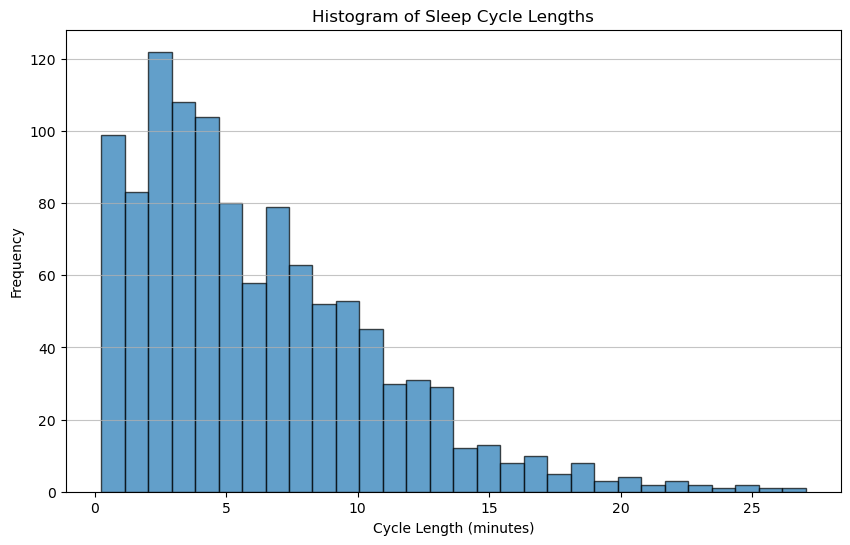

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import glob

def analyze_sleep_cycles(file_path):
    """
    Analyze sleep cycles from a single CSV file.
    Returns DataFrame with start_time, end_time, and cycle_length (in minutes).
    """
    # Read CSV file and ensure timestamp is datetime type
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Find all REM stage end times
    rem_ends = []
    for i in range(len(df)-1):
        if df.iloc[i]['sleepStage'] == 3 and df.iloc[i+1]['sleepStage'] != 3:
            rem_ends.append(df.iloc[i]['Timestamp'])
    
    # Calculate cycle information
    cycles_data = []
    for i in range(len(rem_ends)-1):
        start_time = rem_ends[i]
        end_time = rem_ends[i+1]
        
        # Get all rows between these two REM end times
        mask = (df['Timestamp'] > start_time) & (df['Timestamp'] < end_time)
        between_stages = df[mask]
        
        # Check for Stage 1 periods longer than 2 minutes
        invalid_cycle = False
        stage1_start = None
        
        for idx, row in between_stages.iterrows():
            if row['sleepStage'] == 1:
                if stage1_start is None:
                    stage1_start = row['Timestamp']
            else:
                if stage1_start is not None:
                    stage1_duration = row['Timestamp'] - stage1_start
                    if stage1_duration > timedelta(minutes=2):
                        invalid_cycle = True
                        break
                    stage1_start = None
        
        # If there's an ongoing Stage 1 at the end, check its duration
        if stage1_start is not None:
            stage1_duration = end_time - stage1_start
            if stage1_duration > timedelta(minutes=2):
                invalid_cycle = True
        
        # If cycle is valid, add it to the results
        if not invalid_cycle:
            cycles_data.append({
                'start_time': start_time,
                'end_time': end_time,
                'cycle_length': (end_time - start_time).total_seconds() / 60
            })
    
    return pd.DataFrame(cycles_data)

def process_multiple_files(folder_path):
    """
    Process multiple CSV files in the specified folder.
    Returns a combined DataFrame of cycle lengths.
    """
    all_files = glob.glob(f"{folder_path}/*.csv")
    combined_data = pd.DataFrame()
    
    for file in all_files:
        df = analyze_sleep_cycles(file)
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    
    return combined_data

def plot_histogram(cycles_data):
    """
    Plot a histogram of cycle lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(cycles_data['cycle_length'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histogram of Sleep Cycle Lengths')
    plt.xlabel('Cycle Length (minutes)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Example usage:
folder_path = "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration"
#all_cycles = process_multiple_files(folder_path)
plot_histogram(all_cycles)


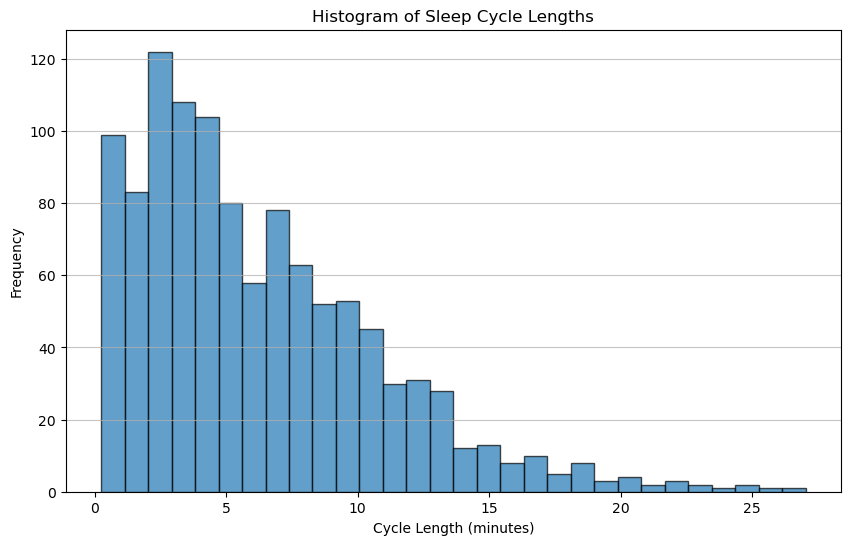

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import glob

def analyze_sleep_cycles(file_path):
    """
    Analyze sleep cycles from a single CSV file.
    Returns DataFrame with start_time, end_time, and cycle_length (in minutes).
    """
    # Read CSV file and ensure timestamp is datetime type
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Find all REM stage end times
    rem_ends = []
    for i in range(len(df)-1):
        if df.iloc[i]['sleepStageConsolidated'] == 3 and df.iloc[i+1]['sleepStageConsolidated'] != 3:
            rem_ends.append(df.iloc[i]['Timestamp'])
    
    # Calculate cycle information
    cycles_data = []
    for i in range(len(rem_ends)-1):
        start_time = rem_ends[i]
        end_time = rem_ends[i+1]
        
        # Get all rows between these two REM end times
        mask = (df['Timestamp'] > start_time) & (df['Timestamp'] < end_time)
        between_stages = df[mask]
        
        # Check for Stage 1 periods longer than 2 minutes
        invalid_cycle = False
        stage1_start = None
        
        for idx, row in between_stages.iterrows():
            if row['sleepStageConsolidated'] == 1:
                if stage1_start is None:
                    stage1_start = row['Timestamp']
            else:
                if stage1_start is not None:
                    stage1_duration = row['Timestamp'] - stage1_start
                    if stage1_duration > timedelta(minutes=2):
                        invalid_cycle = True
                        break
                    stage1_start = None
        
        # If there's an ongoing Stage 1 at the end, check its duration
        if stage1_start is not None:
            stage1_duration = end_time - stage1_start
            if stage1_duration > timedelta(minutes=2):
                invalid_cycle = True
        
        # If cycle is valid, add it to the results
        if not invalid_cycle:
            cycles_data.append({
                'start_time': start_time,
                'end_time': end_time,
                'cycle_length': (end_time - start_time).total_seconds() / 60
            })
    
    return pd.DataFrame(cycles_data)

def process_multiple_files(folder_path):
    """
    Process multiple CSV files in the specified folder.
    Returns a combined DataFrame of cycle lengths.
    """
    all_files = glob.glob(f"{folder_path}/*.csv")
    combined_data = pd.DataFrame()
    
    for file in all_files:
        df = analyze_sleep_cycles(file)
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    
    return combined_data

def plot_histogram(cycles_data):
    """
    Plot a histogram of cycle lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(cycles_data['cycle_length'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histogram of Sleep Cycle Lengths')
    plt.xlabel('Cycle Length (minutes)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Example usage:
folder_path = "/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration_consolidated"
all_cycles = process_multiple_files(folder_path)
plot_histogram(all_cycles)


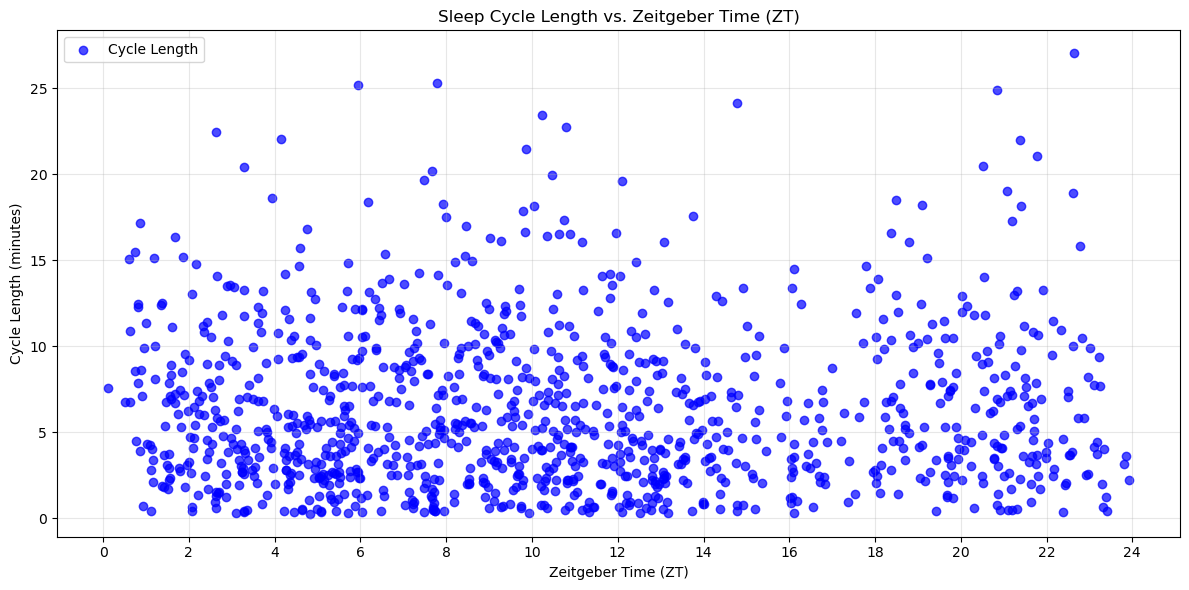

In [29]:
import numpy as np

def convert_to_zt(start_time):
    """
    Convert a timestamp to Zeitgeber Time (ZT) with 09:00:00 as ZT 0.
    """
    # Define ZT 0 as 09:00:00
    zt_zero = start_time.replace(hour=9, minute=0, second=0, microsecond=0)
    
    # Calculate time difference in hours
    zt_offset = (start_time - zt_zero).total_seconds() / 3600
    
    # Wrap ZT to [0, 24) range
    return zt_offset % 24

def add_zt_column(cycles_data):
    """
    Add ZT (Zeitgeber Time) column to the cycles data DataFrame.
    """
    cycles_data['ZT'] = cycles_data['start_time'].apply(convert_to_zt)
    return cycles_data

def plot_cycle_length_vs_zt(cycles_data):
    """
    Plot a scatter plot of cycle lengths vs. ZT.
    """
    # Add ZT column
    cycles_data = add_zt_column(cycles_data)
    
    # Scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(cycles_data['ZT'], cycles_data['cycle_length'], alpha=0.7, color='blue', label='Cycle Length')
    plt.title('Sleep Cycle Length vs. Zeitgeber Time (ZT)')
    plt.xlabel('Zeitgeber Time (ZT)')
    plt.ylabel('Cycle Length (minutes)')
    plt.xticks(np.arange(0, 25, 2))  # Tick marks every 2 ZT hours
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# all_cycles = process_multiple_files(folder_path)
plot_cycle_length_vs_zt(all_cycles)
